# First graded assignment - analysis of model quality

In this notebook, we show how to analyse your final trained model's performance on the test set. We will show you how to plot a confusion matrix and how to visualise errors, e.g. to analyse which samples have been misclassified. Especially when you are working with images, it is important to look at (some examples of) your data, as well as at the errors your model makes.

Obviously, while tuning your model, you can do the same analyses, but **only on the validation set!**

## Setting things up

First you need to do the necessary imports again, mount your drive and load the data. Here, we will only need the test set, for evaluation purposes.



In [1]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pandas as pd
import os

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.constraints import MaxNorm

TensorFlow 2.x selected.
2.1.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [31]:
# Load the data: CIFAR100 with 20 class labels
( _ , _ ), ( x_test , r_test_class ) = cifar100.load_data(label_mode='coarse')

r_test_class = np.squeeze(r_test_class)

num_classes = 20

# And we do the same standardization as in the first assignment
x_test = x_test.astype('float32')
x_test /= 255.0

# Numebr of test samples
N_test = x_test.shape[0]

# the labels from the downloaded data are integer numbers
# for a multi-class classification task, we again convert each integer
# to a vector with 19 zeros and a single '1', corresponding to the right class
r_test = tf.keras.utils.to_categorical(r_test_class, num_classes)

# Labels
labels = [
'aquatic mammals',
'fish',
'flowers',
'food containers',
'fruit and vegetables',
'household electrical devices',
'household furniture',
'insects',
'large carnivores',
'large man-made outdoor things',
'large natural outdoor scenes',
'large omnivores and herbivores',
'medium-sized mammals',
'non-insect invertebrates',
'people',
'reptiles',
'small mammals',
'trees',
'vehicles 1',
'vehicles 2'
]

print('x_test shape:', x_test.shape)
print(x_test.shape[0], 'test samples')

x_test shape: (10000, 32, 32, 3)
10000 test samples


## Load model and run it on the test data



In [32]:
# fill in the path of the model you want to evaluate here
modelpath="/content/gdrive/My Drive/Colab Notebooks/DL2020/GA2/final_model.h5"

tested_model=tf.keras.models.load_model(modelpath)
predictions = tested_model.predict(x_test)

# the predictions are class probabilities, 
# the argmax code line below finds the index of the class with the highest probability
test_predicted_class = np.argmax(predictions,axis=1)
misclassified = np.where(test_predicted_class!=r_test_class)[0]

# misclassified is a vector that contains the indices of all misclassified samples
print("There are ",misclassified.shape[0]," misclassified samples in the test set.")
print("The first 9 look like this:")


There are  2869  misclassified samples in the test set.
The first 9 look like this:


Our scoring measure is accuracy, but it is often useful to look at the performance of the model for individual classes. The measures commonly used in this case are called *precision*, *recall* and *F1-score* (definitions can be found [here](https://en.wikipedia.org/wiki/Confusion_matrix) ).

Below, we use an sklearn function to calculate these measures.

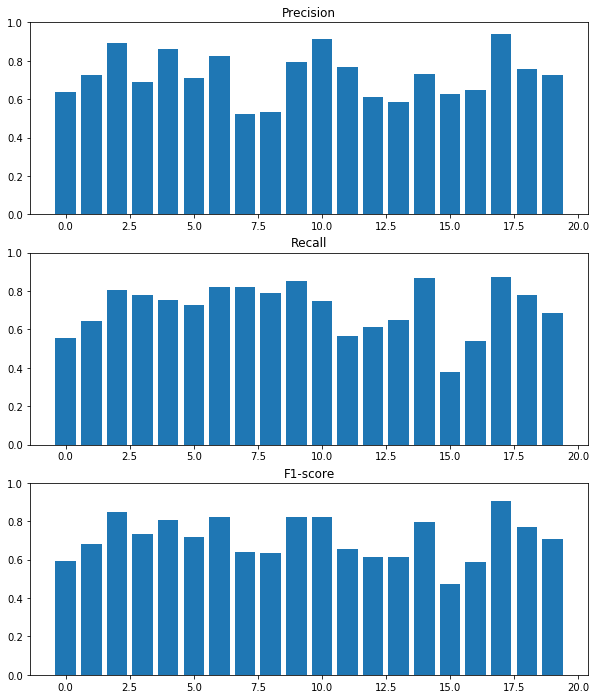

In [57]:
from sklearn.metrics import precision_recall_fscore_support as score

precision, recall, f1, _ = score(r_test_class, test_predicted_class)

plt.figure(figsize=(10,12))

tick_marks = np.arange(num_classes)
plt.subplot(3,1,1)
plt.bar(np.arange(20), precision)
plt.ylim([0.0,1])
plt.title("Precision")
plt.subplot(3,1,2)
plt.bar(np.arange(20), recall)
plt.title("Recall")
plt.ylim([0.0,1])
plt.subplot(3,1,3)
plt.bar(np.arange(20), f1)
plt.ylim([0.0,1])
plt.title("F1-score")
plt.show()

# print('precision: {}'.format(precision))
# print('recall: {}'.format(recall))
# print('fscore: {}'.format(f1))

## Visualise errors

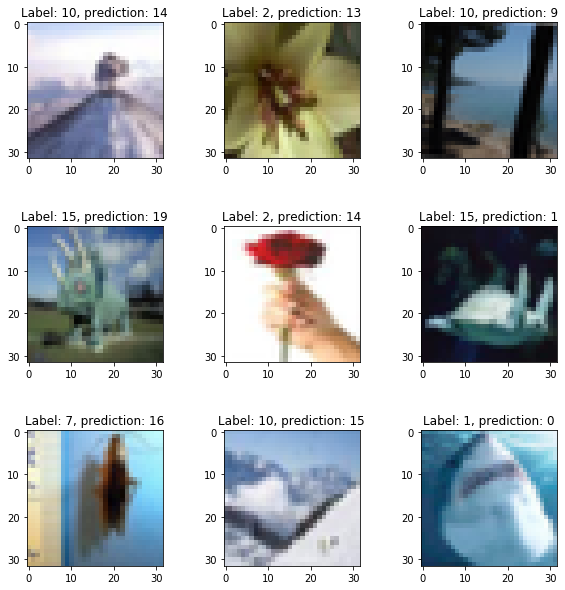

In [36]:
f = plt.figure(figsize=(10,10));
for idx in range(9):
    mis_index = misclassified[idx]
    plt.subplot(3,3,idx+1)
    plt.subplots_adjust(hspace=0.5)
    plt.title("Label: " + str(r_test_class[mis_index]) 
              + ", prediction: " + str(test_predicted_class[mis_index]))
    plt.imshow(x_test[mis_index,:], cmap='Greys', interpolation='None')

We can go further and find some of the misclassified examples about which the model is most certain:


In [0]:
# the functions below have been borrowed/adapted from the notebook:
# https://www.tensorflow.org/tutorials/keras/classification


# this function plots the image with some annotations
def plot_image(predictions, true_label, img):
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                100*np.max(predictions),
                                true_label),
                                color=color)


# this function shows the predictions for this sample
def plot_value_array(predictions, true_label):
  plt.grid(False)
  plt.xticks(range(20))
  plt.yticks([])
  thisplot = plt.bar(range(20), predictions, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

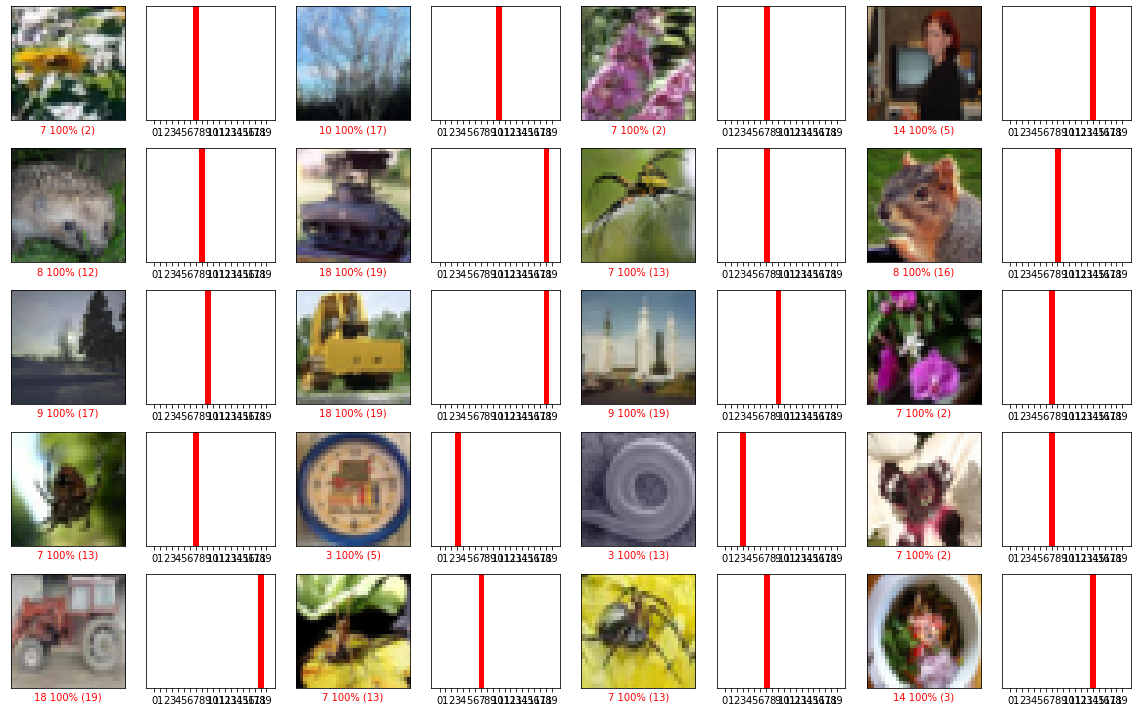

In [59]:
# probabilities for class that will be predicted
maxprob = np.max(predictions, axis=1)

# find 20 most certain misclassified samples
most_certain = np.argsort(maxprob[misclassified])
most_certain = misclassified[most_certain[-20:]]

# now we visualise the samples we found

# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  idx=most_certain[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(predictions[idx], r_test_class[idx], x_test[idx])
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(predictions[idx], r_test_class[idx])
plt.tight_layout()
plt.show()

## Plotting confusion matrices

You can use the function defined below to plot a confusion matrix. This shows how often each class is confused with each other class.

In [0]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(true_labels, predictions, 
                          classes =[], 
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    This code is adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    """
    cm = confusion_matrix(true_labels, predictions)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)
    
    plt.figure(figsize = (10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    #tick_marks = np.arange(num_classes)
    #plt.xticks(tick_marks, labels, rotation=45)
    #plt.yticks(tick_marks, labels)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()



Confusion matrix, without normalization


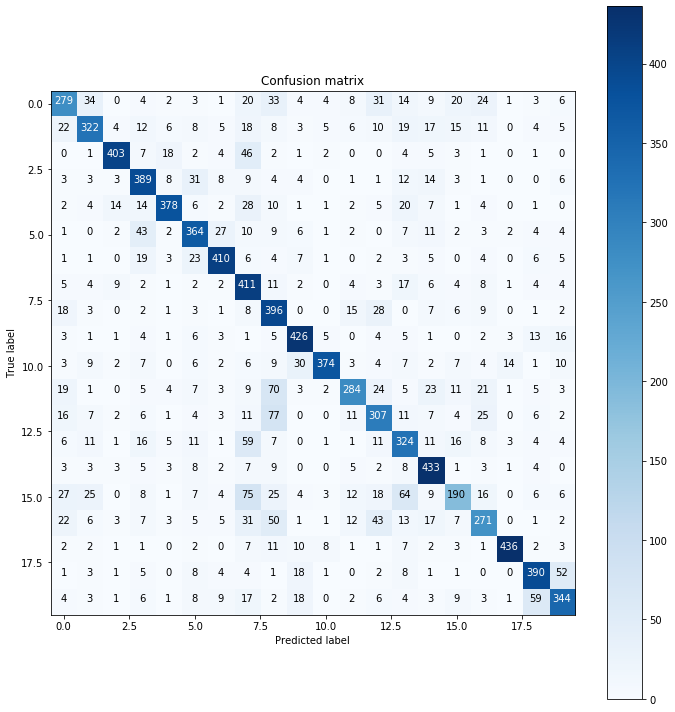

In [50]:
plot_confusion_matrix(r_test_class, test_predicted_class)

Normalized confusion matrix


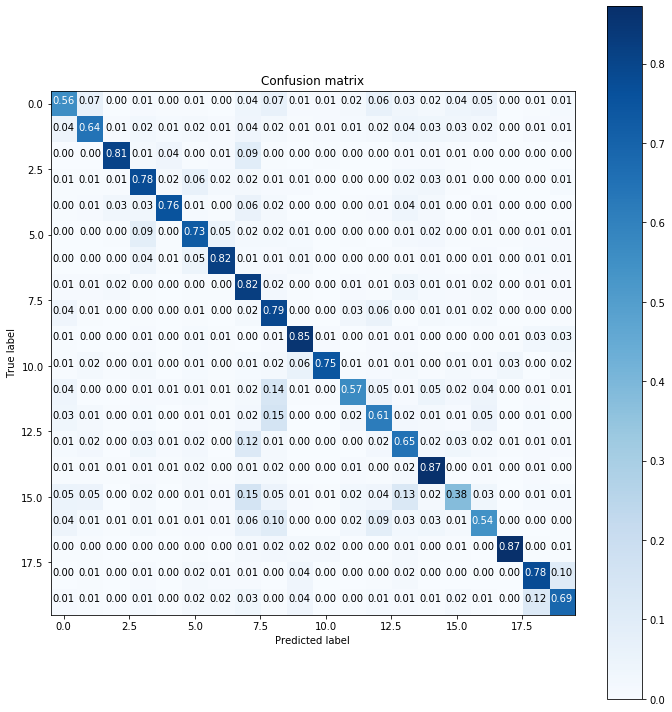

In [51]:

plot_confusion_matrix(r_test_class, test_predicted_class, normalize=True)

Since the classes are balanced, a normalised and an unnormalised confusion matrix will give you similar information. If they are not, it is useful to analyse both. Because the number of misclassified samples is so small, in this case the unnormalised version will be easier to analyse.